# Lets begin with the training of the model

### Adding transformations and basic dataset structure

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import random_split
import random
import os
#import Image
from PIL import Image

# Check if MPS (Apple's Metal Performance Shaders) or CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your dataset
data_dir = "./dataset/"


# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a slightly larger size before cropping
    transforms.RandomCrop(224),     # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images
    transforms.RandomRotation(10),      # Randomly rotate the images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Lambda(lambda img: overlay_human_silhouette(img)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
# List full path of silhouette images
silhouette_image_paths = [os.path.join("./silhoutte/", path) for path in os.listdir("./silhoutte/") if path.endswith('.png')]

# Load silhouette images
silhouette_images = [Image.open(path).convert("RGBA") for path in silhouette_image_paths]

# Define a function to overlay human silhouette
def overlay_human_silhouette(image):
    random.randint(0, 1)
    if random.randint(0, 1) > 0.5:
        return image
    silhouette = random.choice(silhouette_images)
    silhouette = silhouette.resize((random.randint(50, 100), random.randint(100, 200)))

    x, y = random.randint(0, image.width - silhouette.width), random.randint(0, image.height - silhouette.height)
    image.paste(silhouette, (x, y), silhouette)
    return image


### Creating the dataset and its loaders

In [25]:
from sklearn.model_selection import train_test_split

# Split dataset indices into train, validation, and test sets
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=val_size + test_size, stratify=[label for _, label in dataset.samples])
val_idx, test_idx = train_test_split(test_idx, test_size=test_size / (val_size + test_size), stratify=[dataset.samples[i][1] for i in test_idx])

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

# Calculate class weights for the training set
train_class_counts = Counter([dataset.samples[i][1] for i in train_idx])
train_class_weights = {cls: 1.0/count for cls, count in train_class_counts.items()}

# Create weights for each sample in the training set
train_sample_weights = [train_class_weights[dataset.samples[i][1]] for i in train_idx]

# Create a WeightedRandomSampler for the training set
weighted_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

# Modify DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_m, sampler=weighted_sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_m)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_m)


### Inference and validation of dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


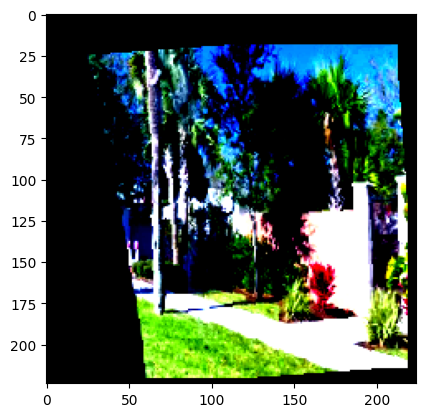

Label: 0


In [32]:
import matplotlib.pyplot as plt

# Fetch one batch of images from the train_loader
images, labels = next(iter(train_loader))

# Display the first image in this batch
image = images[0]

# Convert the image from PyTorch tensor to a NumPy array
# and change the order of dimensions for plotting
image = image.numpy().transpose(1, 2, 0)

# Plot the image
plt.imshow(image)
plt.show()

# Optionally, print the label of the image
print("Label:", labels[0].item())


### Visualising class distribution 

Counter({0: 20, 1: 20})
40


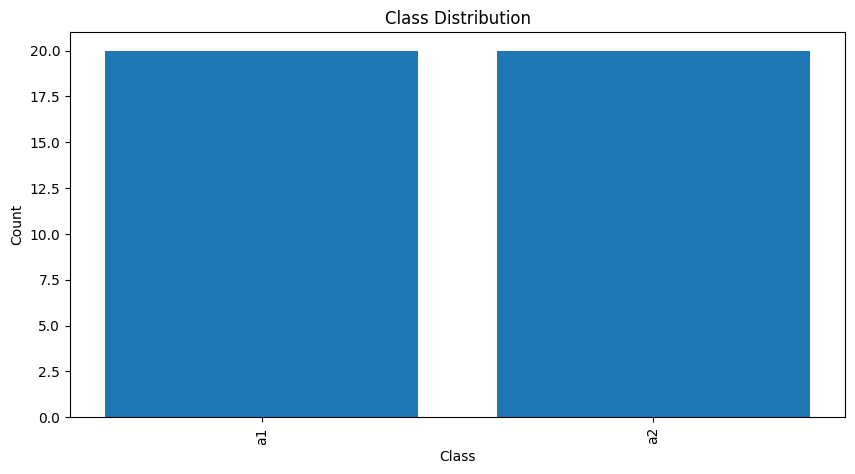

In [33]:

# view class distribution
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# get count of each class
label_counts = Counter(dataset.targets)
total_count = len(dataset.targets)
print(label_counts)
print(total_count)

#PLOT
#find the class names
class_names = dataset.classes
labels = class_names
counts = label_counts.values()
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
#make it a bit mor wide
plt.xticks(rotation=90)
plt.show()


In [35]:
# Name of the classes
dataset.classes

['a1', 'a2']

# Model definition and training

### Defining a Custom model

In [6]:
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLabZoneModel(nn.Module):
    def __init__(self, num_classes=37):
        super(CustomLabZoneModel, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Adjust the input features size accordingly
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of the model
model = CustomLabZoneModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Defining pretrained Resnet50 Model with some layers unfrozen

In [9]:
# Load a pre-trained ResNet50 model
model_resnet50 = models.resnet50(pretrained=True)

# Unfreeze some of the layers for fine-tuning
for name, child in model_resnet50.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# Modify the final layer for  len(dataset.classes) classes
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs,  len(dataset.classes))

model_resnet50 = model_resnet50.to(device)

# Define loss function and optimizer for ResNet50
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()


/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Defining resnet101 pretrained

In [36]:
# Load a pre-trained ResNet101 model
model_resnet101 = models.resnet101(pretrained=True)

# Modify the final layer for  len(dataset.classes) classes
num_ftrs = model_resnet101.fc.in_features
model_resnet101.fc = nn.Linear(num_ftrs,  len(dataset.classes))

model_resnet101 = model_resnet101.to(device)

# Define loss function and optimizer for ResNet101
optimizer = optim.Adam(model_resnet101.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Defining resnet18 pretrained

In [43]:
# Load a pre-trained model (ResNet18 in this case) and modify it
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Adjusting for the number of classes
model_resnet18 = model_resnet18.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Defining Training loop

In [47]:

# Helper function to calculate metrics
def calculate_metrics(loader, modell):
    modell.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modell(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



def train_model(modell, num_epochs=10, run_name=""):
    for epoch in range(num_epochs):
        modell.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = modell(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_loader, modell)
        # Calculate validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_loader, modell)

        print(f"Epoch {epoch+1} / {num_epochs}.." \
              f"Train loss: {running_loss/len(train_loader):.3f}.." \
              f"Train accuracy: {train_accuracy:.3f}.." \
              f"Train precision: {train_precision:.3f}.." \
              f"Train recall: {train_recall:.3f}.." \
              f"Train f1: {train_f1:.3f}.." \
              f"Validation accuracy: {val_accuracy:.3f}.." \
              f"Validation precision: {val_precision:.3f}.." \
                f"Validation recall: {val_recall:.3f}.." \
                f"Validation f1: {val_f1:.3f}")
        
        # Logging metrics to W&B
        # wandb.log({
        #     "Epoch": epoch+1,
        #     "Loss": running_loss/len(train_loader),
        #     "Train Accuracy": train_accuracy,
        #     "Train Precision": train_precision,
        #     "Train Recall": train_recall,
        #     "Train F1": train_f1,
        #     "Validation Accuracy": val_accuracy,
        #     "Validation Precision": val_precision,
        #     "Validation Recall": val_recall,
        #     "Validation F1": val_f1
        # })

        #check if directory exists
        if not os.path.exists(f"./models/{run_name}/"):
            os.makedirs(f"./models/{run_name}/")
        # Save model checkpoints to W&B
        
        torch.save(modell.state_dict(), f"./models/{run_name}/"+f"epoch_{epoch+1}.pth")
        # wandb.save(f"./models/{run_name}_epoch_{epoch+1}.pth")

    print("Finished Training")






### Run the training for your specific instance and model

In [48]:
name_of_training = "custom_simple"

# Initialize a new W&B run
# wandb.init(project="PicfPos", name=name)

# Watch the model to log all gradients and parameters
# wandb.watch(model)
# Train the model
train_model(model_resnet18, num_epochs=10, run_name=name_of_training)

## Remember to close the W&B run when done
# wandb.finish()

Epoch 1 / 10..Train loss: 0.245..Train accuracy: 0.964..Train precision: 0.966..Train recall: 0.964..Train f1: 0.964..Validation accuracy: 1.000..Validation precision: 1.000..Validation recall: 1.000..Validation f1: 1.000
Epoch 2 / 10..Train loss: 0.202..Train accuracy: 1.000..Train precision: 1.000..Train recall: 1.000..Train f1: 1.000..Validation accuracy: 1.000..Validation precision: 1.000..Validation recall: 1.000..Validation f1: 1.000
Epoch 3 / 10..Train loss: 0.310..Train accuracy: 0.714..Train precision: 0.799..Train recall: 0.714..Train f1: 0.625..Validation accuracy: 0.667..Validation precision: 0.800..Validation recall: 0.667..Validation f1: 0.625
Epoch 4 / 10..Train loss: 0.070..Train accuracy: 0.821..Train precision: 0.864..Train recall: 0.821..Train f1: 0.810..Validation accuracy: 0.667..Validation precision: 0.800..Validation recall: 0.667..Validation f1: 0.625
Epoch 5 / 10..Train loss: 0.138..Train accuracy: 0.714..Train precision: 0.835..Train recall: 0.714..Train f1: 0

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optionally, you can save the trained model

In [49]:
torch.save(model.state_dict(), 'model.pth')

NameError: name 'model' is not defined